<a href="https://colab.research.google.com/github/nusc2016/DS-Unit-2-Linear-Models/blob/master/module3/Aaron_Huizenga_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

### The data set being read in is from 2019.

In [0]:
%matplotlib inline
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [456]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [457]:
# I need to clean the data before I can move forward. I have tried to do them all 
# in once code, but it hasn't worked so I will do them individually since I am only 
# doing two different cells.

df = df.drop(df.columns[6], axis=1)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [458]:
df = df.drop(df.columns[8], axis=1)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
# Since there are some missing values I will write a function to replace the 
# missing values. 

df = df.replace(np.nan, 0)

In [460]:
# Next I want to check to make sure that the work has been completed and check 
# any remaining missing values

df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [461]:
one_fam = df[(df['SALE_PRICE'] >= 100000) &
   (df['SALE_PRICE'] <= 2000000) &
   (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]

print(one_fam.shape)
one_fam.sample(5)

(3164, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18038,4,OTHER,01 ONE FAMILY DWELLINGS,1,10866,60,A1,100-11 199TH STREET,11423.0,1.0,0.0,1.0,"2,500",1322.0,1915.0,1,A1,354500,03/29/2019
13125,2,OTHER,01 ONE FAMILY DWELLINGS,1,3608,59,A2,2065 HOMER AVENUE,10473.0,1.0,0.0,1.0,"2,250",1540.0,1960.0,1,A2,495000,03/07/2019
1140,4,OTHER,01 ONE FAMILY DWELLINGS,1,2468,15,A5,51-28 IRELAND STREET,11373.0,1.0,0.0,1.0,"2,142",1860.0,1940.0,1,A5,840000,01/08/2019
19156,5,OTHER,01 ONE FAMILY DWELLINGS,1,2631,20,A1,34 MILDRED AVENUE,10314.0,1.0,0.0,1.0,"5,000",1298.0,1901.0,1,A1,200000,04/04/2019
11420,3,OTHER,01 ONE FAMILY DWELLINGS,1,7963,63,A1,524 EAST 85TH STREET,11236.0,1.0,0.0,1.0,"2,500",1056.0,1925.0,1,A1,585000,02/27/2019


###  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [462]:
one_fam.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [463]:
# I need to convert SALE DATE datetime type and set the cut off for the train and test data.

one_fam['SALE_DATE']= pd.to_datetime(one_fam['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-04-01')
train = one_fam[one_fam['SALE_DATE'] < cutoff]
test  = one_fam[one_fam['SALE_DATE'] >= cutoff]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [464]:
# Using the dtype function to make sure that SALE_DATE was changed to datetime

one_fam.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [465]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [466]:
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,A2,558 ELLSWORTH AVENUE,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,A1,16 BAY RIDGE PARKWAY,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,A5,1247 EAST 40TH STREET,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,A9,2314 PLUMB 2ND STREET,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01


In [467]:
one_fam.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.0,3.164000e+03
mean,6908.597029,75.847029,11027.442162,0.987358,0.015803,1.003161,1469.718394,1943.639697,1.0,6.281899e+05
std,3964.333893,160.779187,482.591574,0.114537,0.127241,0.172362,586.645088,26.679176,0.0,2.969134e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.000000e+05
25%,4003.250000,21.000000,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.450000e+05
50%,6269.500000,42.000000,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.650000e+05
75%,10206.250000,69.000000,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,2.000000e+06


### Do one-hot encoding of categorical features.

In [468]:
# I want to use the following function to take a look at the categorical features.

train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,6,OTHER,2390,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
ADDRESS,2517,2507,216-29 114TH ROAD,2,NaT,NaT


In [0]:
# Next I will split the data into train/test.

target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']

features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
# In order for me to one-hot encode I need to import it.

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [472]:
# Function will check work

print(X_train.shape)
X_train.head(5)

(2517, 47)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


In [473]:
# Now I will test the data after encoding.

X_test =  encoder.transform(X_test)
print(X_test.shape)
X_test.head(5) 

(647, 47)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0


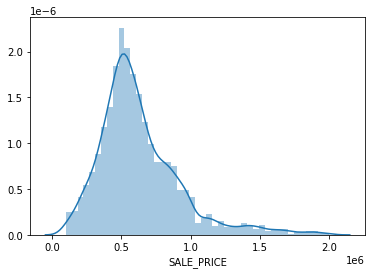

In [474]:
sns.distplot(one_fam['SALE_PRICE'])
plt.show()

### Do feature selection with SelectKBest.

  * As you can see I wasn't able to finish with SelectKBest. This is more than foreign territory but I did give it my all. 

In [0]:
from sklearn.feature_selection import SelectKBest

In [476]:
selector = SelectKBest(k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 11 27 28 35 46] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [477]:
X_train_selected.shape, X_test_selected.shape

((2517, 15), (647, 15))

In [478]:
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print ('Features selected:')
for name in selected_names:
  print (name)

print ('Features excluded:')
for name in unselected_names:
  print (name)

Features selected:
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
COMMERCIAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_S0
Features excluded:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_BEDFORD STUYVESANT
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
ZIP_CODE
RESIDENTIAL_UNITS
TOTAL_UNITS
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_

### Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

In [0]:
features = ['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'TAX_CLASS_AT_PRESENT_1', 'BLOCK',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_S0',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0']

In [0]:
X_train_selected = X_train[features]
X_test_selected = X_test[features]

In [0]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

In [482]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train_selected, y_train)
ridge.alpha_

0.01

In [0]:
from sklearn.linear_model import Ridge
alpha = ridge.alpha_
model = Ridge(alpha = alpha, normalize = True)

In [484]:
model.fit(X_train_selected, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [485]:
print(model.alpha)
print(model.coef_)
print(model.intercept_)

0.01
[ 4.64113984e+04 -3.11608090e+05 -2.73557924e+05  7.65907519e+04
  2.09187231e+05  3.96792566e+05  2.87313546e+05 -9.95660157e+04
 -2.46036352e+01 -2.65275096e+04  7.53848880e+04 -2.24979813e+03
  1.34101875e+04 -6.87511497e+04  4.99213936e+05 -3.20433116e+01
 -9.95660157e+04  2.15356127e+04 -2.88923121e+04  2.02625336e+02
 -3.26747632e+04  7.53848880e+04 -2.24979813e+03  1.34101875e+04
 -6.87511497e+04  4.99213936e+05]
1094065.3792888648


In [0]:
y_pred = model.predict(X_test_selected)

### Get MAE for test set

In [487]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae

161634.83047407508